# Laboratorio no. 7
desarrollo de red neuronal por Marco Jurado carnet 20308

### Preprocesamiento

Se llaman a las librerias necesarias para el desarrollo inicial de este laboratorio siendo estas numpy para manejo de matrices y sus operaciones básicas, matplotlib para poder visualizar los resultados y ImageDataGenerator para poder hacer un aumento de la data obtenida de las imagenes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

Se define el path donde se encuentran las imagenes a evaluar para el desarrollo de la red neuronal.

In [2]:
path = 'malimg_dataset/malimg_paper_dataset_imgs'

Con la siguiente instrucción se busca utilizar la libreria de keras, ImageDataGenerator, normalizando el tamaño de las imagenes a evaluar a un estandar de 64 x 64 y se hace un trabajo por lotes de un tamaño de 10000 imagenes.

In [3]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


Luego con esta siguiente instrucción se busca aprender y observar los indices entregados o asignados a los tipos de imagenes en el set que se nos ha brindado.

In [4]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

Con el uso de next se avanza al siguiente lote de imagenes manteniendo siempre las imagenes obtenidas, sus datos y sus labels en las respectivas variables asignadas.

In [5]:
imgs, labels = next(familias)

Vemos la forma de la matriz imgs para determinar el tamaño de esta.

In [6]:
imgs.shape

(9339, 64, 64, 3)

Podemos ver que tiene una forma de (9339, 64, 64, 3) y ahora vamos a continuar con la matriz de labels...

In [7]:
labels.shape

(9339, 25)

Vemos que labels tiene una forma de (9339, 25).

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Con esta función se hace una conexión entre la etiqueta de la imagen con la información como tal para poder ver mejor dichos datos y demás.

Vamos a ver con el uso de plots de matplotlib las imagenes ya asociadas con sus etiquetas...

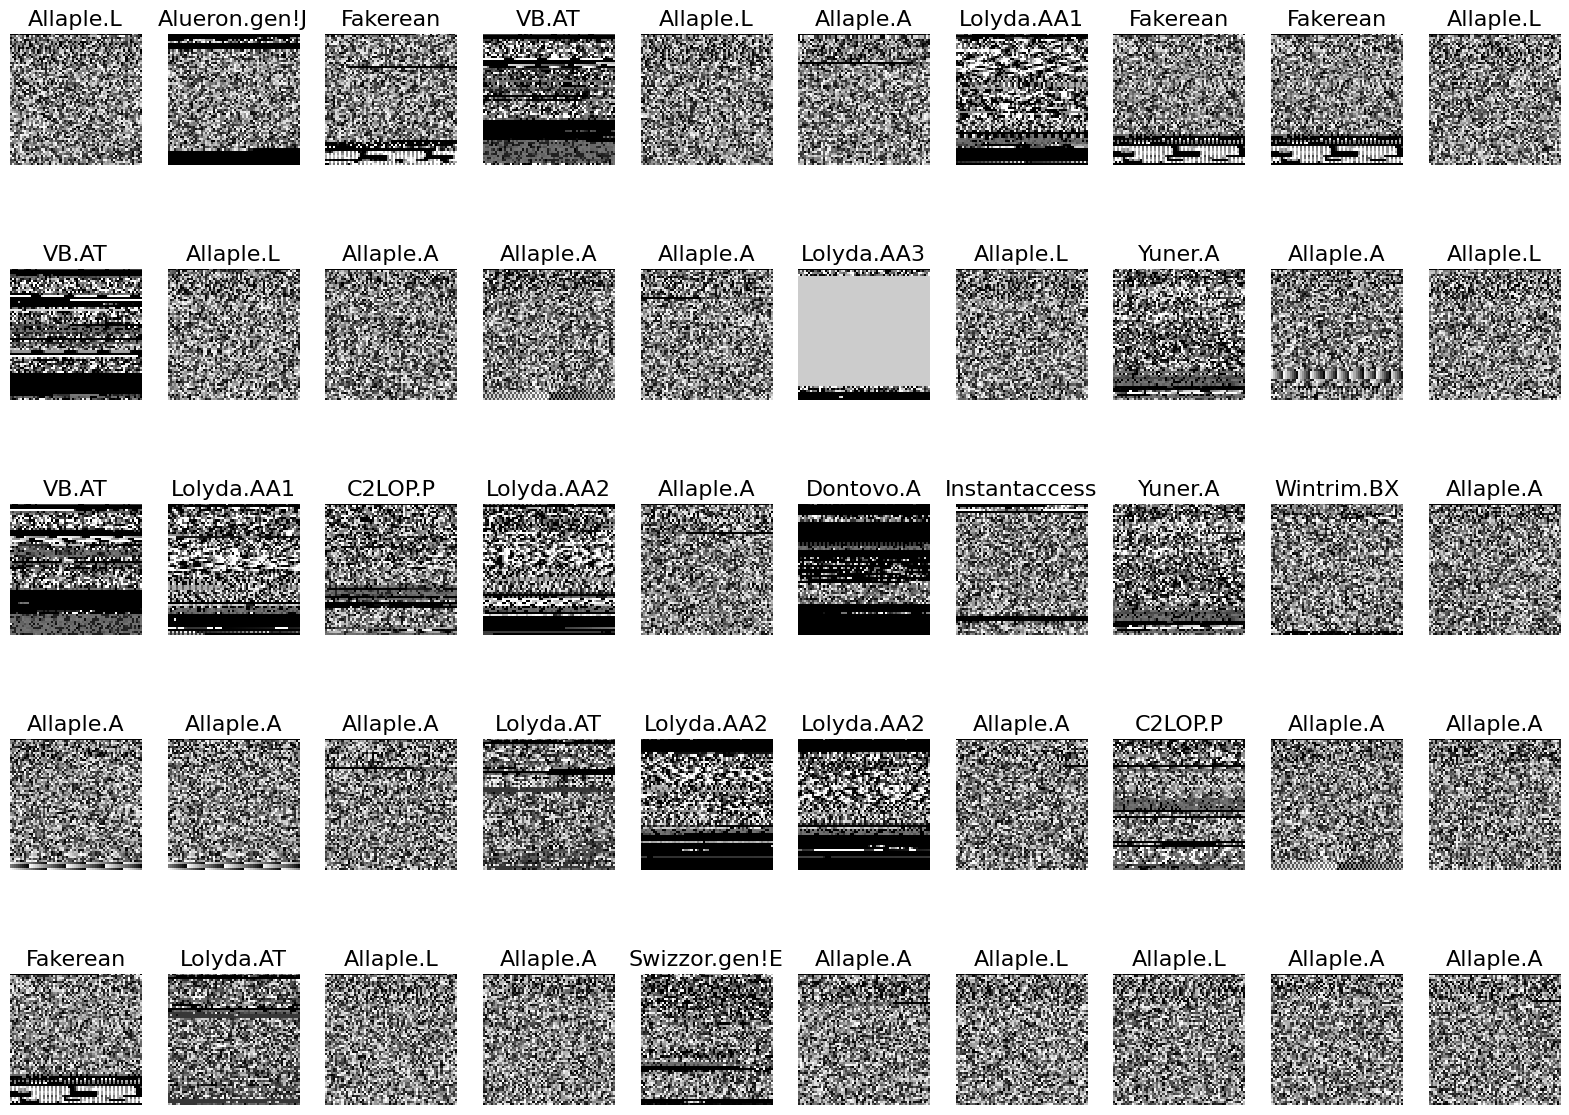

In [9]:

plots(imgs, titles = labels)

Procedemos a desarrollar la red neuronal...

### Red Neuronal (CNN)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from matplotlib.cm import get_cmap

Vamos a normalizar las imagenes y aplicar un encoding a las labels ya que esto permite que el entrenamiento sea mejor y efectivo para la cnn:

In [11]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

Luego separamos el dataset en 70% prueba y 30% entrenamiento:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(familias.class_indices), activation='softmax')
])

1. Capas Convolucionales (Conv2D): Capturan patrones espaciales en las imágenes, como bordes y texturas. Al aumentar el número de filtros en capas más profundas, el modelo puede aprender características más complejas y específicas.

2. Batch Normalization: Normaliza las activaciones de cada capa, reduciendo el número de épocas necesarias para entrenar y mejorando la estabilidad del modelo. También actúa como un regularizador, reduciendo el sobreajuste en algunos casos.

3. Función de Activación ReLU: Se usa por su eficiencia computacional y porque ayuda a mitigar el problema del gradiente desvanecido en redes profundas, permitiendo modelos más robustos y de aprendizaje rápido.

4. Capas de Max Pooling (MaxPooling2D): Reducen la dimensionalidad de los mapas de características, permitiendo que el modelo sea menos sensible a la ubicación exacta de las características en la imagen.

5. Flatten: Convierte los mapas de características tridimensionales en un vector unidimensional, preparando los datos para las capas densas que no aceptan entradas multidimensionales.

6. Capas Densas (Dense): Actúan como clasificadores sobre las características extraídas, donde la última capa densa utiliza la activación 'softmax' para la clasificación multiclase.

7. Dropout: Ayuda a prevenir el sobreajuste "desactivando" aleatoriamente un porcentaje de las neuronas durante el entrenamiento, lo que fuerza al modelo a no depender demasiado de cualquier característica en particular.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       2

Ya definido el modelo ha utilizar para la cnn procedemos a compilarlo...

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Vamos con el entrenamiento del modelo utilizando la instrucción de fit

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
205/205 [==============================] - 60s 280ms/step - loss: 1.1733 - accuracy: 0.6622 - val_loss: 2.2432 - val_accuracy: 0.5214
Epoch 2/5
205/205 [==============================] - 55s 270ms/step - loss: 0.2665 - accuracy: 0.9140 - val_loss: 7.4203 - val_accuracy: 0.4222
Epoch 3/5
205/205 [==============================] - 57s 276ms/step - loss: 0.2012 - accuracy: 0.9368 - val_loss: 12.0184 - val_accuracy: 0.0742
Epoch 4/5
205/205 [==============================] - 54s 264ms/step - loss: 0.1448 - accuracy: 0.9544 - val_loss: 3.4465 - val_accuracy: 0.4375
Epoch 5/5
205/205 [==============================] - 55s 266ms/step - loss: 0.1336 - accuracy: 0.9556 - val_loss: 10.1807 - val_accuracy: 0.1238


Finalmente vamos a realizar la evaluación del modelo y vamos a guardar el mismo

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

88/88 [==============================] - 4s 48ms/step - loss: 10.1807 - accuracy: 0.1238


Miramos el loss del modelo:

In [18]:
test_loss

10.180691719055176

Miramos el accuracy del modelo:

In [19]:
test_accuracy

0.12384011596441269

In [20]:
model.save('malware_classifier_model.h5')

Vamos a ver las metricas del modelo a continación utilizando librerias como lo es seaborn y classification reports

In [21]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

88/88 [==============================] - 4s 48ms/step


In [22]:
print(" ---> Classification Report obtenido:")
print(classification_report(y_true_labels, y_pred_labels))

 ---> Classification Report obtenido:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       1.00      0.03      0.05        36
           2       0.00      0.00      0.00       853
           3       1.00      0.01      0.03       462
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        66
           8       0.00      0.00      0.00        59
           9       0.98      1.00      0.99        47
          10       1.00      0.01      0.02       113
          11       0.00      0.00      0.00       131
          12       0.00      0.00      0.00        58
          13       0.33      1.00      0.50        63
          14       1.00      0.97      0.98        29
          15       0.00      0.00      0.00        57
          16       0.00      0.00      0.00

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

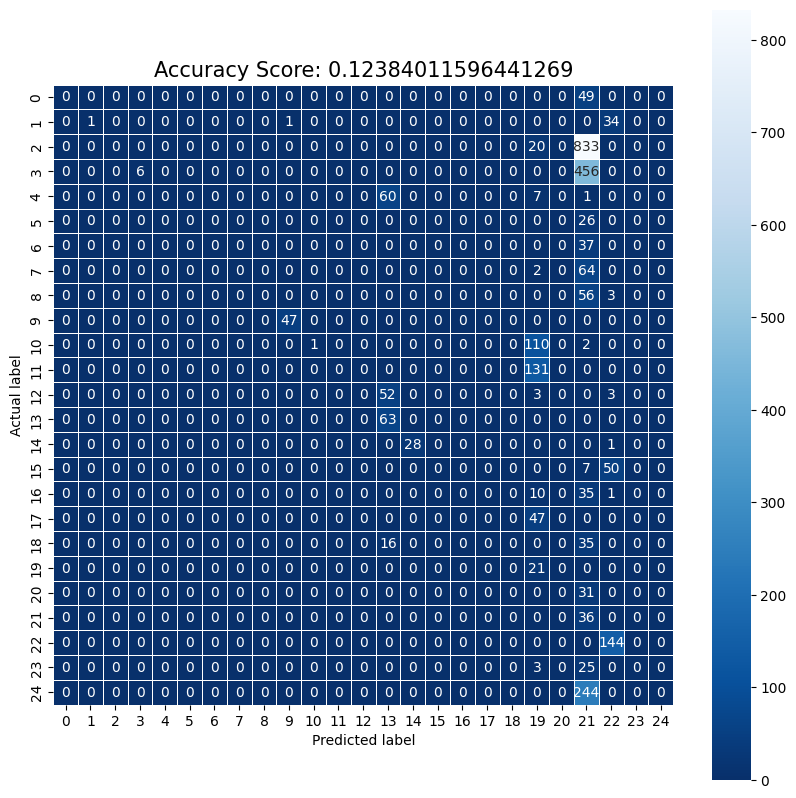

In [23]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Accuracy Score: {0}'.format(test_accuracy), size = 15)
    plt.show()

plot_confusion_matrix(y_true_labels, y_pred_labels)

La matriz de confusión revela una alta cantidad de verdaderos positivos, como lo indican los grandes números en la diagonal principal, lo cual es un indicador excelente de que el modelo clasifica correctamente la mayoría de las instancias. Los valores bajos o ceros fuera de la diagonal principal sugieren que hay muy pocos errores de clasificación entre clases, lo cual es ideal.

Vamos a observar la curva ROC y AUC del modelo:

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_train.shape[1]

In [25]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

C:\Users\marco\AppData\Local\Temp\ipykernel_33888\2033182652.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


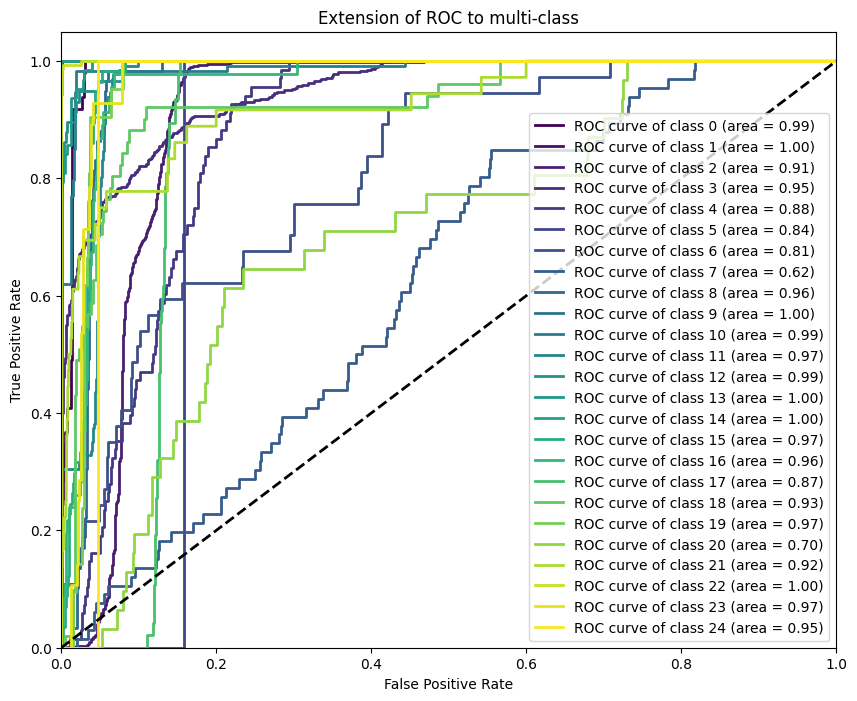

In [26]:
cmap = get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_classes))

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of ROC to multi-class')
plt.legend(loc="lower right")
plt.show()

La gráfica de las curvas ROC muestra que muchas clases tienen un área bajo la curva (AUC) de 1.00, esto nos dice que es una clasificación perfecta para esas clases o labels. La falta de lineas cerca a la línea diagonal nos dice que el modelo tiene un desempeño excepcional en la mayoría de las clases. Sin embargo, algunas clases tienen AUC ligeramente menor, como 0.95, lo que podría indicar que hay margen para mejorar en esas categorías específicas.

# Segunda parte

In [27]:
#!pip install adversarial-robustness-toolbox
#!pip install --upgrade adversarial-robustness-toolbox

Vamos a utilizar adversarial-robustness-toolbox (ART) para realizar los ataques y probar la seguridad del modelo

In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import to_categorical

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Probamos cargar el modelo para verificar que si lo hemos guardado correctamente en el paso anterior...

In [29]:
path = 'malware_classifier_model.h5'
model = load_model(path)

Utilizamos un classifier de KerasClassifier para poder realizar los ataques respectivamente

In [30]:
#tf.compat.v1.disable_eager_execution()

In [32]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(64, 64, 3), loss_object=tf.keras.losses.CategoricalCrossentropy(), clip_values=(0, 1))

## Primer ataque de Evasión con FastGradientMethod

El Fast Gradient Sign Method (FGSM) es un ataque adversario que modifica ligeramente las imágenes de entrada para engañar a un modelo de aprendizaje profundo. Este ataque usa el gradiente de la función de pérdida del modelo para crear estas perturbaciones, añadiendo un pequeño cambio (definido por ε o `eps`) en la dirección que más incrementa la pérdida. El objetivo es hacer que el modelo cometa errores, incluso con modificaciones mínimas a los datos originales.


In [33]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv = attack_fgsm.generate(x=X_test)
loss, accuracy = model.evaluate(x_test_adv, y_test)
print(f"Loss on adversarial examples: {loss:.4f}")
print(f"Accuracy on adversarial examples: {accuracy:.2%}")

88/88 [==============================] - 5s 50ms/step - loss: 10.2066 - accuracy: 0.1235
Loss on adversarial examples: 10.2066
Accuracy on adversarial examples: 12.35%


- **Pérdida (Loss):** 10.2066, lo que indica un aumento significativo en la dificultad para el modelo al clasificar correctamente las imágenes modificadas.
- **Precisión (Accuracy):** 12.35%, demostrando que el modelo experimenta un gran desafío al identificar correctamente las imágenes alteradas, lo que refleja una drástica reducción en su capacidad de clasificación en comparación con las imágenes no alteradas.

## Segundo ataque extracción e inferencia con MIFace

In [38]:
from art.attacks.inference.model_inversion import MIFace

El ataque MIFace es un método de inversión de modelo que intenta reconstruir las imágenes originales a partir de las predicciones de un modelo. Utiliza un proceso de optimización iterativa para ajustar una imagen inicial hasta que las salidas del modelo se asemejan a las predicciones objetivo. Se configura con parámetros como max_iter para el número máximo de iteraciones y threshold para la precisión deseada. Este ataque pone de manifiesto vulnerabilidades potenciales en modelos que manejan datos sensibles, señalando riesgos significativos de privacidad.

Model inversion: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RG

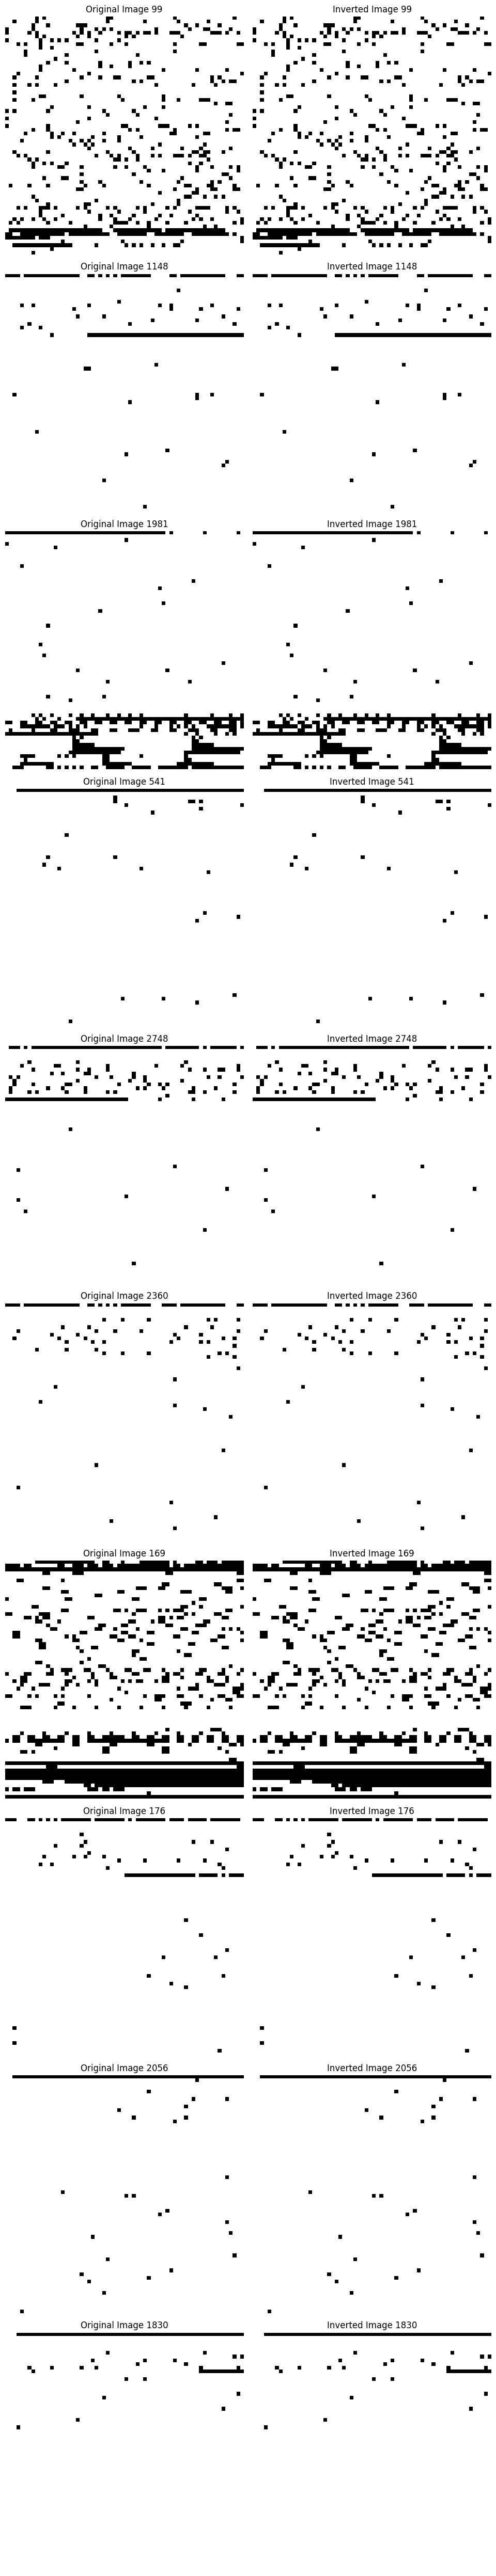

In [42]:
attack = MIFace(classifier=classifier, max_iter=5000, threshold=1e-6)
indices = np.random.choice(range(len(X_test)), size=10, replace=False)
results = []

for index in indices:
    x_target = np.expand_dims(X_test[index], axis=0)
    x_inverted = attack.infer(x_target)
    results.append((X_test[index], x_inverted[0], index))

fig, axes = plt.subplots(nrows=len(results), ncols=2, figsize=(10, 5 * len(results)))
for i, (orig, inv, idx) in enumerate(results):
    axes[i, 0].imshow(orig, cmap='gray')
    axes[i, 0].set_title(f'Original Image {idx}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(inv, cmap='gray')
    axes[i, 1].set_title(f'Inverted Image {idx}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error

# Calcula el MSE para cada par de imagen original y reconstruida
mse_scores = [mean_squared_error(orig.flatten(), inv.flatten()) for orig, inv, _ in results]

# Puedes calcular el promedio de MSE para tener una idea general de la eficacia del ataque
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE: {average_mse}")


Average MSE: 20452.460546875
